<a href="https://colab.research.google.com/github/akhavan12/discrete_covid_model/blob/master/Discrete_Model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interact_manual, interactive
from ipywidgets import GridspecLayout
from ipywidgets import FloatSlider
pd.options.display.max_rows = 999
import scipy as scipy
from scipy.interpolate import make_interp_spline, BSpline

In [0]:
df_Italy = pd.read_excel('https://github.com/akhavan12/discrete_covid_model/raw/master/Country_Trends.xlsx',sheet_name='Italy')

![alt text](https://raw.githubusercontent.com/akhavan12/discrete_covid_model/master/Model_Discrete_v8.svg)

In [0]:
## Each state represents time from onset in one conditions (E,Symp,M,W,V)
## when moving from one day to another, the states increment (E(t) -> E(t+1))
## the change or staying in each condition, and state has it's own probability

#H -- > E[ state 0, time t]--> P_E(state,E) --> + E(State 1, t+1)
#                          --> P_E(state,Symp) --> + Symp(State 0, t+1) -->(Testing ratio)
#                          --> P_H(state,H) --> + H(t+1)
#S(state=1,t) -- > M(state=0,t+1) --P_M(state=1~14,M)-- > M(state=1,t+2)
#                                 --P_M(state=1~14,W)-- > W(state=1,t+2)-----|P_W(state=1~14,V) ---> V(state=0, t=t+3) -->| P_R(state=1~14,V) --> R
#                                 --P_M(state=1~14,R)-- > R(state=1,t+2)     |P_W(state=1~14,D) --->                      | P_D(state=1~14,V) --> D
#                                                                            |P_R(state=1~14,R) ---> 
# E(state 0,  t+1) = H(t)* (M + W)*Beta/N
# H(t+1) = H(t) - E(State 0, t+1)

In [0]:
def set_probs_M(Probs):
  ### M,R,Severe
  Probs["M"] = [[1.00,0.00,0.00], #0
          [0.80,0.00,0.20], #1
          [0.80,0.00,0.20], #2
          [0.70,0.00,0.30], #3
          [0.70,0.00,0.30], #4
          [0.60,0.00,0.30], #5
          [0.50,0.00,0.50], #6
          [0.50,0.00,0.50], #7
          [0.50,0.00,0.50], #8
          [0.30,0.30,0.40], #9
          [0.30,0.40,0.30], #10
          [0.20,0.60,0.20], #11
          [0.10,0.70,0.10], #12
          [0.05,0.90,0.05], #13
          [0.00,1.00,0.00]] #14 
  
def set_probs_Severe(Probs):
  ### Severe,R,V,D



  Probs["Severe"] = [
          [0.7,0,0.3,0,1], #0
          [0.6,0.05,0.3,0.05,1], #1
          [0.6,0.05,0.3,0.05,1], #2
          [0.4,0.25,0.3,0.05,1], #3
          [0.3,0.3,0.3,0.1,1], #4
          [0.2,0.15,0.5,0.15,1], #5
          [0.1,0.25,0.5,0.15,1], #6
          [0,0.25,0.5,0.25,1], #7
          [0,0.2,0.5,0.3,1], #8
          [0,0.2,0.5,0.3,1], #9
          [0,0.2,0.5,0.3,1], #10
          [0,0.2,0.5,0.3,1], #11
          [0,0.2,0.5,0.3,1], #12
          [0,0.2,0.5,0.3,1], #13
          [0,0,1,0,1]] #14

def set_probs_ventilator(Probs):
  ### V,R,D 
  Probs["ventilator"] = [
          [0.50,0.15,0.35], #0
          [0.40,0.15,0.45], #1
          [0.40,0.15,0.45], #2
          [0.30,0.15,0.45], #3
          [0.30,0.15,0.45], #4
          [0.20,0.25,0.55], #5
          [0.20,0.25,0.55], #6
          [0.10,0.15,0.75], #7
          [0.10,0.15,0.75], #8
          [0.05,0.15,0.80], #9
          [0.05,0.15,0.80], #10
          [0.05,0.15,0.80], #11
          [0.05,0.15,0.80], #12
          [0.05,0.15,0.80], #13
          [0.00,0.15,0.85]] #14

def set_probs_Symp(Probs):
  ### Symp,M,H.   0: not tested, 1: tested positive ,2: tested negative
  Probs['Symp'] =[[0.20,  0.80*0.70,  0.80*0.30], #0 Testing and + cases go to Mild cases , negative cases go back to Healthy
                  [0.00,  1.00,       0.00]]      #1 ###  all remainings go to Mild cases 

def set_probs_E(Probs):
  ### E,H,Symp
  Probs["E"] = [[1.00,0.00,0.00], #0 ### first day of exposure
                [0.30,0.50,0.20], #1        
                [0.20,0.50,0.30], #2 
                [0.10,0.60,0.40], #3
                [0.05,0.65,0.50], #4
                [0.00,0.60,0.60]] #5 



In [0]:
Probs={}
H = []
E = []
Symp = []
Tested = []
M = []
V = []
W = []
R = []
D = []
N = 0

def initialize(MaxTime, H_0, E_0_0, M_0_0, Symp_0_0):
  global H
  global E
  global Symp
  global Tested
  global M
  global V
  global W
  global R
  global D
  global Probs
  global N
  N = H_0

  H=np.zeros(MaxTime) ## healthy population has 1 class
  E=np.zeros([5,MaxTime]) ## Exposed population has 5 classes

  Symp=np.zeros([2,MaxTime]) ## Sympt population has 2 classes
  Tested = np.zeros(MaxTime) ## Sympt population has 2 classes
  M=np.zeros([15,MaxTime]) ## Mild population has 14 classes
  V=np.zeros([15,MaxTime]) ## Ventilator population has 14 classes
  W=np.zeros([15,MaxTime]) ## Severe population has 14 classes
  R=np.zeros(MaxTime) ## Recovered population has 1 class
  D=np.zeros(MaxTime) ## Dead population has 1 class
  
  H[0] = H_0
  E[0,0] = E_0_0
  M[0,0]=M_0_0
  Symp[0,0]=Symp_0_0



In [0]:
def Simulate(MaxTime,Beta):
  global H
  global E
  global Symp
  global Tested
  global M
  global V
  global W
  global R
  global D
  global Probs

  results = []
  for t in range(MaxTime-1):

    ### transfer previous days number of recovered cases
    R[t+1] = R[t]
    D[t+1] = D[t]
   ### when the case has symptoms, it is removed from the population
   
    H[t+1] = H[t]- E[0,t]

  ### at time t calculate all the values of t+1 for all the states

    for state in range(0,4):
      ## Stay exposed conditions
      #print('t:',t,'-->',E[state,t]*Probs["E"][state][0],E[state,t]*Probs["E"][state][1],E[state,t]*Probs["E"][state][2],'-->',E[state,t])
      E[state+1,t+1] =  E[state,t]*Probs["E"][state][0] 
      #print(state,t,E[state,t])
      ## go back to healthy population
      #H[t+1] = H[t+1] + E[state,t] * Probs["E"][state][1]
      ## become symtomic
      Symp[0,t+1] = Symp[0,t+1] + E[state,t] * Probs["E"][state][2]

    ### Symptomatic states 
    #################################################
    Symp[1,t+1] = Symp[0,t] * Probs["Symp"][0][0]         ### state 0 remain sympt
    Tested[t] = Tested[t] + Symp[0,t] * (1-Probs["Symp"][0][0]) 

    ### from Symptomatic to mild --> where testing also happens
    M[0,t+1] = Symp[0,t] * Probs["Symp"][0][1]           ### From state 0 to Mild state 0
    
    H[t+1] = H[t+1] + Symp[0,t] * Probs["Symp"][0][2]           ### From state 0 to Mild state 0

    M[0,t+1] = M[0,t+1] +  Symp[1,t] * Probs["Symp"][1][1] ### From state 1 to Mild state 0
    #print(f"t: {t} => S0*P[0,1]: {Symp[0,t] *Probs['Symp'][0][1]}==>> {M[0,t+1]}\n S0*P[0,1]: {Symp[1,t] *Probs['Symp'][1][1]} ==>> {M[1,t+1]}")
    #################################################

    for state in range(0,14):
      ### M,R,Severe
      M[state+1,t+1] =  M[state,t] * Probs["M"][state][0] ## from state= state --> to state+1

      R[t+1] = R[t+1] + M[state,t] * Probs["M"][state][1] ## from Mild to recovered

      W[0,t+1] = W[0,t+1] + M[state,t] * Probs["M"][state][2]

    for state in range(0,14):
      ### Severe,R,V,D
      W[state+1,t+1] =  M[state,t] * Probs["Severe"][state][0]
      R[t+1] = R[t+1] + W[state,t] * Probs["Severe"][state][1]
      V[0,t+1] =  W[state,t] * Probs["Severe"][state][2]
      D[t+1] = D[t+1] + W[state,t] * Probs["Severe"][state][3]

    for state in range(0,14):
      ### V,R,D 
      V[state+1,t+1] =  V[state,t] * Probs["ventilator"][state][0]
      R[t+1] = R[t+1] + V[state,t] * Probs["Severe"][state][1]
      D[t+1] = D[t+1] + V[state,t] * Probs["Severe"][state][2]

    results.append({
    "time":t,
    "Sucseptible" : H[t],
    "Mild_0": M[0,t].sum(),
    "Mild_1": M[1,t].sum(),
    "Mild_2": M[2,t].sum(),
    "Mild_3": M[3,t].sum(),
    "Mild_4": M[4,t].sum(),
    "Mild_5": M[5,t].sum(),
    "Mild_6": M[6,t].sum(),
    "Mild_7": M[7,t].sum(),
    "Mild_8": M[8,t].sum(),
    "E": E[:,t].sum(),
    "Symp_0" : Symp[0,t].sum(),
    "Symp_1" : Symp[1,t].sum(),
    "Symp" : Symp[:,t].sum(),
    "Mild" : M[:,t].sum(),
    "Severe" :  W[:,t].sum(),
    "Ventilator" : V[:,t].sum(),
    "Death" : D[t],
    "Recovered" : R[t],
    "Tested" : Tested[t]})
    
    E[0,t+1] = ( H[t] * (M[:,t].sum()+W[:,t].sum())/N)* Beta

  return pd.DataFrame(results)


# Static control of the results

In [0]:
H_0 = 6000000
E_0 = 800
B = 1.5
set_probs_M(Probs)
set_probs_Severe(Probs)
set_probs_Symp(Probs)
set_probs_ventilator(Probs)
set_probs_E(Probs)
MaxTime =90
initialize(MaxTime=MaxTime,H_0=H_0, E_0_0=E_0, M_0_0=0, Symp_0_0=0)

df_res=Simulate(MaxTime=MaxTime, Beta = B)


In [0]:
df_res['sums']=df_res[[	'Mild'	,'Severe',	'Ventilator',	'Death'	,'Recovered']].sum(axis=1)
disp=df_res[['Sucseptible','E','Symp',	'Mild'
        ,'Severe',	'Ventilator',	'Death'	
        ,'Recovered','sums']].tail(60).style.background_gradient(cmap='viridis')
disp

,Sucseptible,E,Symp,Mild,Severe,Ventilator,Death,Recovered,sums
29,5950495.737792,17601.060651,2148.517485,3955.061252,2460.617799,0.000000,704.519276,1394.798269,8514.996596
30,5942682.339468,20343.167853,2480.327059,4577.864999,2850.067114,0.000000,817.811458,1618.911669,9864.655239
31,5933645.591860,23521.119784,2864.706581,5294.731005,3299.602495,0.000000,948.927117,1878.380807,11421.641424
32,5923196.187173,27185.657402,3311.380419,6120.663280,3816.435638,0.000000,1100.666049,2179.097966,13216.862934
33,5911124.775090,31396.581656,3828.733367,7074.455403,4411.273039,0.000000,1276.200352,2527.358065,15289.286859
34,5897193.320454,36232.312097,4424.863343,8177.218525,5098.009447,0.000000,1479.169249,2930.118247,17684.515468
35,5881125.215774,41790.642598,5109.631612,9451.416160,5892.293742,0.000000,1713.793198,3395.487127,20452.990228
36,5862598.823169,48182.618670,5896.034121,10921.295512,6810.468916,0.000000,1984.973716,3933.136288,23649.874433
37,5841245.250790,55526.311739,6800.088872,12614.365307,7869.805058,0.000000,2298.370885,4554.465222,27337.006473
38,5816647.517317,63945.831122,7839.741787,14562.852950,9089.772518,0.000000,2660.477651,5272.592412,31585.695531


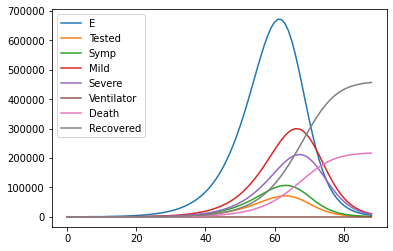

In [0]:
df_res[['E','Tested','Symp',	'Mild'	,'Severe',	'Ventilator',	'Death'	,'Recovered']].plot()

## Interactive form of the algorithm

In [0]:
df_results=pd.DataFrame()
def Interactive_deriv(H_0,E_0,B):

  gap=15


  global df_results
  set_probs_M(Probs)
  set_probs_Severe(Probs)
  set_probs_Symp(Probs)
  set_probs_ventilator(Probs)
  set_probs_E(Probs)
  initialize(MaxTime=100,H_0=H_0, E_0_0=E_0, M_0_0=10, Symp_0_0=10)
  results=Simulate(MaxTime=100, Beta = B)
  
  f,ax = plt.subplots(1,1,figsize=(10,8))
  #ax.plot(M.sum(axis=0),color='orange',label='mild')
  #ax.plot(W.sum(axis=0),color='navy',label='severe')
  #ax.plot(V.sum(axis=0),color='purple',label='ventilator')
  ax.plot(M.sum(axis=0)+W.sum(axis=0)+V.sum(axis=0),color='orange',label='simulation active cases')
  ax.plot(df_Italy.index+gap, df_Italy['active'],'--',color='orange',label='Italy active cases')
  #ax.plot(Tested.cumsum(),'-o',color='gray',label='Simulation')


  #ax.plot(R,color='green',label='recovered')
  ax.plot(D,color='red',label='dead')
  ax.plot(df_Italy.index+gap, df_Italy['total death'],'--',color='red',label='Italy total death')
  #ax.plot(H,color='black',label='healthy')
  ax.set_xlim(xmin=0,xmax=80)
  
  
  ax.plot(V.sum(axis=0)+W.sum(axis=0) ,color='purple',label='ventilator + severe')
  ax.plot(df_Italy.index+gap, df_Italy['icu'],'--',color='purple',label='active icu')
  #ax.plot(df_Italy.index+30, df_Italy['total test'],'-*',color='gray',label='Italy Total Tested')

  ax.legend(fontsize=14)
  plt.show()
  df_results=pd.DataFrame(results)

  return 

w = interactive(
    Interactive_deriv,
    H_0=      FloatSlider(min=10000, max=5000000, continuous_update=False, readout_format='.3f',   step=1000, value=2000000, description = 'H t0'), 
    E_0=      FloatSlider(min=10, max=10000,       continuous_update=False, readout_format='.3f',   step=1, value=5000, description = 'Exposed t0') ,
    B=        FloatSlider(min=0.50, max=3.00,     continuous_update=False, readout_format='.3f',   step=.05, value=1.15, description = 'Beta'))


In [0]:
w

interactive(children=(FloatSlider(value=2000000.0, continuous_update=False, description='H t0', max=5000000.0,…